# Classical monetary approach

## purchasing power parity - consumer price index

multistep: mutistpe forecast  
m: montly data

### dependent variable

- "DEXJPUS","fred"

### independent variable

- "USACPIALLMINMEI","fred"
- "JPNCPIALLMINMEI","fred"


In [1]:
%matplotlib inline
import datetime
import pandas_datareader.data as web
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from statsmodels.tsa.api import VECM
start="1971/1/1";end='2019/12/31'
from dateutil.relativedelta import relativedelta
from scipy.stats import t
from scipy.stats import norm
def tcdf(x,n): #t-distribution
    if x>=0:
        y=(1-t.cdf(x,n))
    else:
        y=t.cdf(x,n)
    return y
def ncdf(x): #t-distribution
    if x>=0:
        y=(1-norm.cdf(x))
    else:
        y=norm.cdf(x)
    return y

In [2]:
e =web.DataReader("DEXJPUS","fred",start,end)
p1 =web.DataReader("USACPIALLMINMEI","fred",start,end)#m
p2 =web.DataReader("JPNCPIALLMINMEI","fred",start,end)#m
p3 =web.DataReader("PPIACO","fred",start,end)#m
p4 =web.DataReader("PITGCG01JPM661N","fred",start,end)#m

In [3]:
ee=e.copy().resample('MS').last()
tsd=pd.concat([ee,p1,p2],axis=1)
tsd.columns=['ee','p1','p2']
print(tsd.head())
print(tsd.tail())

                ee         p1    p2
DATE                               
1971-01-01  357.72  16.792044  32.8
1971-02-01  357.56  16.834236  32.8
1971-03-01  357.42  16.876427  32.9
1971-04-01  357.40  16.918618  33.3
1971-05-01  357.40  17.003000  33.4
                ee          p1     p2
DATE                                 
2019-08-01  106.30  108.244556  101.8
2019-09-01  108.11  108.329360  101.9
2019-10-01  108.09  108.577022  102.2
2019-11-01  109.47  108.518798  102.3
2019-12-01  108.67  108.420071  102.3


In [4]:
def backtest_ols_dp(tsd,tw,pt):#tw time window pt:predicting time
    pred=[]
    real0=[]
    real9=[]
    tsd0=np.log(tsd).copy()
    for i in range(tw+1,len(tsd)+1-1):
        yy=tsd0.iloc[i-tw:i:1,0]
        y0=tsd0.iloc[i-tw-1:i:1,0].diff().dropna()
        x0=(tsd0.iloc[i-tw-1:i:1,1]-tsd0.iloc[i-tw-1:i:1,2]).diff().dropna()
        x0=sm.add_constant(x0.values)
        res= sm.OLS(y0, x0).fit()
        real0.append(np.exp(tsd0.iloc[i-1:i,0][-1]))
        if i<len(tsd)+1-pt:
            x9=(tsd0.iloc[i-1:i+pt:1,1]-tsd0.iloc[i-1:i+pt:1,2]).diff().dropna()
            if pt==1:
                x9=np.insert(x9.values,0,1)
            else:
                x9=sm.add_constant(x9.values)
            pred0=res.predict(x9)[-1:]
            pred.append(np.exp(pred0+yy.iloc[-1]))
            real9.append(np.exp(tsd0.iloc[i+pt-1:i+pt:1,0].values))
    return real0,real9,pred

def performance_eval(real0,real9,pred):
    p0=pd.DataFrame(real0)
    p9=pd.DataFrame(real9)
    pp=pd.DataFrame(pred)
    p0_=p0[:len(p9)]
    pp_=pp[:len(p9)]
    wrs=p0_[(p9<p0_)&(pp_<p0_)].count()
    wrl=p0_[(p9>p0_)&(pp_>p0_)].count()
    wr=float((wrs+wrl)/p0_.count())
    #wrp=tcdf(float((wr-0.5)/np.sqrt(0.25/p0_.count())),p0_.count())[0]
    wrp=ncdf(float((wr-0.5)/np.sqrt(0.25/p0_.count())))
    d_x=(pp_-p9)**2
    d_rw=(p9-p0_)**2
    d=d_x-d_rw
    d_=float(d.mean())
    #dm=tcdf(float(d_/np.sqrt(((d-d_)**2).sum()/len(d)**2)),p0_.count())[0]
    dm=ncdf(float(d_/np.sqrt(((d-d_)**2).sum()/len(d)**2)))
    rmse=float(d_x.mean()/d_rw.mean())
    return rmse,dm,wr,wrp

def performance_report(real0,real9,pred):
    ab,dm,wr,wrp=performance_eval(real0,real9,pred)
    print('{0:20s}{1:5d} mse_r {2:7.4f} mse_p {3:7.2f} wr {4:7.4f} wrp {5:7.2f} len {6:4d}'
          .format(model,isp,ab,dm,wr,wrp,len(real9)))    

In [5]:
pstart=datetime.date(1983,1,1)
pend=datetime.date(1994,12,31)        
model='first difference OLS'
oosp=3
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*10,oosp*50,6):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS   30 mse_r  0.9782 mse_p    0.18 wr  0.4857 wrp    0.37 len  140
first difference OLS   36 mse_r  0.9658 mse_p    0.05 wr  0.4786 wrp    0.31 len  140
first difference OLS   42 mse_r  0.9861 mse_p    0.22 wr  0.5000 wrp    0.50 len  140
first difference OLS   48 mse_r  1.0013 mse_p    0.47 wr  0.5214 wrp    0.31 len  140
first difference OLS   54 mse_r  1.0103 mse_p    0.26 wr  0.5000 wrp    0.50 len  140
first difference OLS   60 mse_r  1.0022 mse_p    0.44 wr  0.5214 wrp    0.31 len  140
first difference OLS   66 mse_r  0.9799 mse_p    0.06 wr  0.5714 wrp    0.05 len  140
first difference OLS   72 mse_r  0.9840 mse_p    0.10 wr  0.5714 wrp    0.05 len  140
first difference OLS   78 mse_r  0.9963 mse_p    0.38 wr  0.5429 wrp    0.16 len  140
first difference OLS   84 mse_r  1.0008 mse_p    0.47 wr  0.5143 wrp    0.37 len  140
first difference OLS   90 mse_r  0.9842 mse_p    0.06 wr  0.5571 wrp    0.09 len  140
first difference OLS   96 mse_r  0.9763 mse_p    0.01 

In [6]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
model='first difference OLS'
oosp=3
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*10,oosp*50,12):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS   30 mse_r  1.0557 mse_p    0.01 wr  0.4671 wrp    0.21 len  152
first difference OLS   42 mse_r  1.0481 mse_p    0.03 wr  0.4671 wrp    0.21 len  152
first difference OLS   54 mse_r  1.0367 mse_p    0.02 wr  0.4868 wrp    0.37 len  152
first difference OLS   66 mse_r  1.0233 mse_p    0.03 wr  0.4737 wrp    0.26 len  152
first difference OLS   78 mse_r  1.0174 mse_p    0.07 wr  0.4474 wrp    0.10 len  152
first difference OLS   90 mse_r  1.0230 mse_p    0.02 wr  0.4934 wrp    0.44 len  152
first difference OLS  102 mse_r  1.0176 mse_p    0.04 wr  0.4803 wrp    0.31 len  152
first difference OLS  114 mse_r  1.0177 mse_p    0.04 wr  0.4539 wrp    0.13 len  152
first difference OLS  126 mse_r  1.0243 mse_p    0.01 wr  0.4539 wrp    0.13 len  152
first difference OLS  138 mse_r  1.0197 mse_p    0.04 wr  0.4671 wrp    0.21 len  152


In [7]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
model='first difference OLS'
oosp=3
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*10,oosp*50,12):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS   30 mse_r  1.0213 mse_p    0.22 wr  0.5214 wrp    0.31 len  140
first difference OLS   42 mse_r  1.0325 mse_p    0.10 wr  0.5357 wrp    0.20 len  140
first difference OLS   54 mse_r  1.0361 mse_p    0.04 wr  0.5286 wrp    0.25 len  140
first difference OLS   66 mse_r  1.0330 mse_p    0.02 wr  0.4929 wrp    0.43 len  140
first difference OLS   78 mse_r  1.0323 mse_p    0.01 wr  0.5000 wrp    0.50 len  140
first difference OLS   90 mse_r  1.0255 mse_p    0.01 wr  0.5000 wrp    0.50 len  140
first difference OLS  102 mse_r  1.0151 mse_p    0.06 wr  0.5286 wrp    0.25 len  140
first difference OLS  114 mse_r  1.0210 mse_p    0.01 wr  0.4857 wrp    0.37 len  140
first difference OLS  126 mse_r  1.0116 mse_p    0.21 wr  0.4286 wrp    0.05 len  140
first difference OLS  138 mse_r  1.0139 mse_p    0.13 wr  0.4786 wrp    0.31 len  140


In [8]:
pstart=datetime.date(1983,1,1)
pend=datetime.date(1994,12,31)        
model='first difference OLS'
oosp=12
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*10,oosp*50,6):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS  120 mse_r  0.9799 mse_p    0.00 wr  0.7710 wrp    0.00 len  131
first difference OLS  126 mse_r  0.9809 mse_p    0.00 wr  0.7786 wrp    0.00 len  131
first difference OLS  132 mse_r  0.9839 mse_p    0.00 wr  0.7634 wrp    0.00 len  131
first difference OLS  138 mse_r  0.9872 mse_p    0.00 wr  0.7328 wrp    0.00 len  131
first difference OLS  144 mse_r  0.9876 mse_p    0.00 wr  0.7481 wrp    0.00 len  131


In [9]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
model='first difference OLS'
oosp=12
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*10,oosp*50,12):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS  120 mse_r  1.0323 mse_p    0.00 wr  0.3706 wrp    0.00 len  143
first difference OLS  132 mse_r  1.0326 mse_p    0.00 wr  0.4545 wrp    0.14 len  143
first difference OLS  144 mse_r  1.0286 mse_p    0.00 wr  0.4895 wrp    0.40 len  143
first difference OLS  156 mse_r  1.0218 mse_p    0.00 wr  0.4895 wrp    0.40 len  143
first difference OLS  168 mse_r  1.0204 mse_p    0.00 wr  0.4476 wrp    0.10 len  143
first difference OLS  180 mse_r  1.0245 mse_p    0.00 wr  0.4056 wrp    0.01 len  143
first difference OLS  192 mse_r  1.0191 mse_p    0.00 wr  0.4266 wrp    0.04 len  143
first difference OLS  204 mse_r  1.0152 mse_p    0.00 wr  0.4476 wrp    0.10 len  143
first difference OLS  216 mse_r  1.0147 mse_p    0.00 wr  0.4615 wrp    0.18 len  143
first difference OLS  228 mse_r  1.0163 mse_p    0.00 wr  0.4545 wrp    0.14 len  143
first difference OLS  240 mse_r  1.0203 mse_p    0.00 wr  0.3916 wrp    0.00 len  143
first difference OLS  252 mse_r  1.0168 mse_p    0.00 

In [10]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
model='first difference OLS'
oosp=12
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*10,oosp*50,24):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS  120 mse_r  1.0217 mse_p    0.00 wr  0.4122 wrp    0.02 len  131
first difference OLS  144 mse_r  1.0204 mse_p    0.00 wr  0.3893 wrp    0.01 len  131
first difference OLS  168 mse_r  1.0239 mse_p    0.00 wr  0.3893 wrp    0.01 len  131
first difference OLS  192 mse_r  1.0236 mse_p    0.00 wr  0.4427 wrp    0.10 len  131
first difference OLS  216 mse_r  1.0124 mse_p    0.01 wr  0.4427 wrp    0.10 len  131
first difference OLS  240 mse_r  1.0164 mse_p    0.00 wr  0.4656 wrp    0.22 len  131
first difference OLS  264 mse_r  1.0187 mse_p    0.00 wr  0.4046 wrp    0.01 len  131
first difference OLS  288 mse_r  1.0115 mse_p    0.02 wr  0.4733 wrp    0.27 len  131
first difference OLS  312 mse_r  1.0106 mse_p    0.03 wr  0.5344 wrp    0.22 len  131
first difference OLS  336 mse_r  1.0163 mse_p    0.00 wr  0.5115 wrp    0.40 len  131
first difference OLS  360 mse_r  1.0148 mse_p    0.01 wr  0.5267 wrp    0.27 len  131
first difference OLS  384 mse_r  1.0109 mse_p    0.02 

In [11]:
pstart=datetime.date(1983,1,1)
pend=datetime.date(1994,12,31)        
model='first difference OLS'
oosp=60
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*1,oosp*50,12):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS   60 mse_r  0.9987 mse_p    0.23 wr  0.6386 wrp    0.01 len   83
first difference OLS   72 mse_r  0.9958 mse_p    0.01 wr  0.7711 wrp    0.00 len   83
first difference OLS   84 mse_r  0.9910 mse_p    0.00 wr  0.8193 wrp    0.00 len   83
first difference OLS   96 mse_r  0.9876 mse_p    0.00 wr  0.9759 wrp    0.00 len   83
first difference OLS  108 mse_r  0.9872 mse_p    0.00 wr  0.9759 wrp    0.00 len   83
first difference OLS  120 mse_r  0.9886 mse_p    0.00 wr  0.9880 wrp    0.00 len   83
first difference OLS  132 mse_r  0.9888 mse_p    0.00 wr  0.9518 wrp    0.00 len   83
first difference OLS  144 mse_r  0.9869 mse_p    0.00 wr  0.9518 wrp    0.00 len   83


In [12]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
model='first difference OLS'
oosp=60
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*1,oosp*50,24):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS   60 mse_r  1.0649 mse_p    0.00 wr  0.2737 wrp    0.00 len   95
first difference OLS   84 mse_r  1.0387 mse_p    0.00 wr  0.3053 wrp    0.00 len   95
first difference OLS  108 mse_r  1.0280 mse_p    0.00 wr  0.3789 wrp    0.01 len   95
first difference OLS  132 mse_r  1.0438 mse_p    0.00 wr  0.2842 wrp    0.00 len   95
first difference OLS  156 mse_r  1.0245 mse_p    0.00 wr  0.4105 wrp    0.04 len   95
first difference OLS  180 mse_r  1.0160 mse_p    0.02 wr  0.4211 wrp    0.06 len   95
first difference OLS  204 mse_r  1.0061 mse_p    0.18 wr  0.4737 wrp    0.30 len   95
first difference OLS  228 mse_r  1.0116 mse_p    0.05 wr  0.4632 wrp    0.24 len   95
first difference OLS  252 mse_r  1.0102 mse_p    0.07 wr  0.4737 wrp    0.30 len   95
first difference OLS  276 mse_r  1.0074 mse_p    0.14 wr  0.4737 wrp    0.30 len   95


In [13]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
model='first difference OLS'
oosp=60
nn=len(tsd.loc[pstart:pend])
for isp in range(oosp*1,oosp*50,36):#10,pt):
    ps=pstart-relativedelta(months=isp*1-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_ols_dp(tsdd,isp,oosp)
        performance_report(real0,real9,pred)

first difference OLS   60 mse_r  1.0363 mse_p    0.00 wr  0.3253 wrp    0.00 len   83
first difference OLS   96 mse_r  1.0267 mse_p    0.00 wr  0.2892 wrp    0.00 len   83
first difference OLS  132 mse_r  1.0222 mse_p    0.00 wr  0.2651 wrp    0.00 len   83
first difference OLS  168 mse_r  1.0194 mse_p    0.00 wr  0.3494 wrp    0.00 len   83
first difference OLS  204 mse_r  1.0130 mse_p    0.00 wr  0.3735 wrp    0.01 len   83
first difference OLS  240 mse_r  1.0170 mse_p    0.00 wr  0.3735 wrp    0.01 len   83
first difference OLS  276 mse_r  1.0160 mse_p    0.00 wr  0.3012 wrp    0.00 len   83
first difference OLS  312 mse_r  1.0209 mse_p    0.00 wr  0.2530 wrp    0.00 len   83
first difference OLS  348 mse_r  1.0207 mse_p    0.00 wr  0.1687 wrp    0.00 len   83
first difference OLS  384 mse_r  1.0181 mse_p    0.00 wr  0.1687 wrp    0.00 len   83
first difference OLS  420 mse_r  1.0190 mse_p    0.00 wr  0.1566 wrp    0.00 len   83


In [14]:
def backtest_VECM(tsd,tw,pt,det):#tw time window pt:predicting time
    pred=[]
    real0=[]
    real9=[]
    tsd0=np.log(tsd.copy())
    for i in range(tw,len(tsd)+1):
        y0=(tsd0.iloc[i-tw:i:1,0])
        x=tsd0.iloc[i-tw:i:1,1]-tsd0.iloc[i-tw:i:1,2]
        tsd00=pd.concat([y0,x],axis=1)
        model = VECM(tsd00,k_ar_diff=0,deterministic=det)
        results = model.fit() 
        real0.append(np.exp(y0.iloc[-1]))
        pp=np.exp(results.predict(pt)[-1][0])
        pred.append(pp)
        if i<len(tsd)+1-pt:
            real9.append(tsd.iloc[i+pt-1,0])
    return real0,real9,pred

In [15]:
pstart=datetime.date(1983,1,1)
pend=datetime.date(1994,12,31)        
nn=len(tsd.loc[pstart:pend])
interval=1
model='VECM'
oosp=3
for isp in range(oosp*20,oosp*200,oosp*5):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'li')
        performance_report(real0,real9,pred)

VECM                   60 mse_r  1.2620 mse_p    0.00 wr  0.4184 wrp    0.03 len  141
VECM                   75 mse_r  1.0635 mse_p    0.06 wr  0.4823 wrp    0.34 len  141
VECM                   90 mse_r  1.0361 mse_p    0.05 wr  0.5177 wrp    0.34 len  141
VECM                  105 mse_r  0.9211 mse_p    0.00 wr  0.5674 wrp    0.05 len  141
VECM                  120 mse_r  0.8922 mse_p    0.01 wr  0.5887 wrp    0.02 len  141
VECM                  135 mse_r  0.8992 mse_p    0.02 wr  0.6099 wrp    0.00 len  141


In [16]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
nn=len(tsd.loc[pstart:pend])
interval=1
model='VECM'
oosp=3
for isp in range(oosp*20,oosp*200,oosp*10):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'na')
        performance_report(real0,real9,pred)

VECM                   60 mse_r  1.1100 mse_p    0.01 wr  0.4379 wrp    0.06 len  153
VECM                   90 mse_r  1.0454 mse_p    0.00 wr  0.3856 wrp    0.00 len  153
VECM                  120 mse_r  1.0366 mse_p    0.01 wr  0.4118 wrp    0.01 len  153
VECM                  150 mse_r  1.0417 mse_p    0.00 wr  0.3791 wrp    0.00 len  153
VECM                  180 mse_r  1.0416 mse_p    0.00 wr  0.4118 wrp    0.01 len  153
VECM                  210 mse_r  1.0113 mse_p    0.24 wr  0.4183 wrp    0.02 len  153
VECM                  240 mse_r  1.0366 mse_p    0.02 wr  0.4183 wrp    0.02 len  153
VECM                  270 mse_r  1.0432 mse_p    0.03 wr  0.4183 wrp    0.02 len  153


In [17]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
nn=len(tsd.loc[pstart:pend])
interval=1
model='VECM'
oosp=3
for isp in range(oosp*20,oosp*200,oosp*10):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'na')
        performance_report(real0,real9,pred)

VECM                   60 mse_r  1.0517 mse_p    0.00 wr  0.4752 wrp    0.28 len  141
VECM                   90 mse_r  1.0303 mse_p    0.04 wr  0.5177 wrp    0.34 len  141
VECM                  120 mse_r  1.0182 mse_p    0.06 wr  0.4681 wrp    0.22 len  141
VECM                  150 mse_r  1.0115 mse_p    0.10 wr  0.4752 wrp    0.28 len  141
VECM                  180 mse_r  1.0172 mse_p    0.02 wr  0.5106 wrp    0.40 len  141
VECM                  210 mse_r  0.9943 mse_p    0.29 wr  0.4965 wrp    0.47 len  141
VECM                  240 mse_r  0.9998 mse_p    0.49 wr  0.5603 wrp    0.08 len  141
VECM                  270 mse_r  1.0188 mse_p    0.10 wr  0.4965 wrp    0.47 len  141
VECM                  300 mse_r  0.9976 mse_p    0.45 wr  0.5177 wrp    0.34 len  141
VECM                  330 mse_r  1.0174 mse_p    0.19 wr  0.5035 wrp    0.47 len  141
VECM                  360 mse_r  1.0355 mse_p    0.03 wr  0.5035 wrp    0.47 len  141
VECM                  390 mse_r  1.0206 mse_p    0.17 

(144, 141, 144)

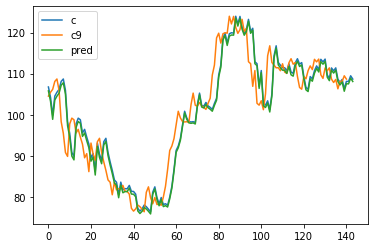

In [18]:
plt.plot(real0[:],label='c')
plt.plot(real9[:],label='c9')
plt.plot(pred[:],label='pred')
plt.legend()
len(real0),len(real9),len(pred)

In [19]:
pstart=datetime.date(1983,1,1)
pend=datetime.date(1994,12,31)        
nn=len(tsd.loc[pstart:pend])
interval=1
model='VECM'
oosp=12
for isp in range(oosp*2,oosp*200,oosp*2):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'li')
        performance_report(real0,real9,pred)

VECM                   24 mse_r  1.4657 mse_p    0.00 wr  0.4470 wrp    0.11 len  132
VECM                   48 mse_r  1.5253 mse_p    0.00 wr  0.2879 wrp    0.00 len  132
VECM                   72 mse_r  1.2282 mse_p    0.00 wr  0.5985 wrp    0.01 len  132
VECM                   96 mse_r  0.9060 mse_p    0.00 wr  0.6818 wrp    0.00 len  132
VECM                  120 mse_r  0.7821 mse_p    0.00 wr  0.8030 wrp    0.00 len  132
VECM                  144 mse_r  0.8688 mse_p    0.01 wr  0.6970 wrp    0.00 len  132


In [20]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
nn=len(tsd.loc[pstart:pend])
interval=1
model='VECM'
oosp=12
for isp in range(oosp*2,oosp*200,oosp*1):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'na')
        performance_report(real0,real9,pred)

VECM                   24 mse_r  2.1127 mse_p    0.00 wr  0.4514 wrp    0.12 len  144
VECM                   36 mse_r  2.0091 mse_p    0.00 wr  0.3264 wrp    0.00 len  144
VECM                   48 mse_r  1.6453 mse_p    0.00 wr  0.2986 wrp    0.00 len  144
VECM                   60 mse_r  1.4289 mse_p    0.00 wr  0.4653 wrp    0.20 len  144
VECM                   72 mse_r  1.4469 mse_p    0.00 wr  0.4167 wrp    0.02 len  144
VECM                   84 mse_r  1.3302 mse_p    0.00 wr  0.2917 wrp    0.00 len  144
VECM                   96 mse_r  1.2366 mse_p    0.00 wr  0.2431 wrp    0.00 len  144
VECM                  108 mse_r  1.1765 mse_p    0.00 wr  0.2431 wrp    0.00 len  144
VECM                  120 mse_r  1.1992 mse_p    0.00 wr  0.4306 wrp    0.05 len  144
VECM                  132 mse_r  1.2180 mse_p    0.00 wr  0.4514 wrp    0.12 len  144
VECM                  144 mse_r  1.1952 mse_p    0.00 wr  0.4514 wrp    0.12 len  144
VECM                  156 mse_r  1.2278 mse_p    0.00 

In [21]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
nn=len(tsd.loc[pstart:pend])
interval=1
model='VECM'
oosp=12
for isp in range(oosp*2,oosp*200,oosp*2):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'na')
        performance_report(real0,real9,pred)

VECM                   24 mse_r  2.6020 mse_p    0.00 wr  0.5455 wrp    0.15 len  132
VECM                   48 mse_r  1.5887 mse_p    0.00 wr  0.4394 wrp    0.08 len  132
VECM                   72 mse_r  1.1616 mse_p    0.00 wr  0.4848 wrp    0.36 len  132
VECM                   96 mse_r  1.1170 mse_p    0.00 wr  0.4545 wrp    0.15 len  132
VECM                  120 mse_r  1.0857 mse_p    0.00 wr  0.4848 wrp    0.36 len  132
VECM                  144 mse_r  1.0501 mse_p    0.01 wr  0.5227 wrp    0.30 len  132
VECM                  168 mse_r  1.0511 mse_p    0.01 wr  0.5000 wrp    0.50 len  132
VECM                  192 mse_r  1.0785 mse_p    0.00 wr  0.5152 wrp    0.36 len  132
VECM                  216 mse_r  0.9726 mse_p    0.07 wr  0.6136 wrp    0.00 len  132
VECM                  240 mse_r  1.0295 mse_p    0.12 wr  0.5227 wrp    0.30 len  132
VECM                  264 mse_r  1.0724 mse_p    0.01 wr  0.4394 wrp    0.08 len  132
VECM                  288 mse_r  1.0236 mse_p    0.24 

In [22]:
pstart=datetime.date(1983,1,1)
pend=datetime.date(1994,12,31)        
nn=len(tsd.loc[pstart:pend])
nnn=len(tsd)

interval=1
model='VECM'
oosp=60
for isp in range(36,oosp*200,12):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'li')
        performance_report(real0,real9,pred)
    if len(tsdd)+isp>=nnn:
        break

VECM                   36 mse_r  2.5294 mse_p    0.00 wr  0.4762 wrp    0.33 len   84
VECM                   48 mse_r  2.9143 mse_p    0.00 wr  0.5238 wrp    0.33 len   84
VECM                   60 mse_r  2.1651 mse_p    0.00 wr  0.5238 wrp    0.33 len   84
VECM                   72 mse_r  1.4428 mse_p    0.00 wr  0.6786 wrp    0.00 len   84
VECM                   84 mse_r  0.9121 mse_p    0.11 wr  0.8095 wrp    0.00 len   84
VECM                   96 mse_r  0.6385 mse_p    0.00 wr  0.8810 wrp    0.00 len   84
VECM                  108 mse_r  0.5507 mse_p    0.00 wr  0.9167 wrp    0.00 len   84
VECM                  120 mse_r  0.5703 mse_p    0.00 wr  0.9286 wrp    0.00 len   84
VECM                  132 mse_r  0.8706 mse_p    0.04 wr  0.7619 wrp    0.00 len   84
VECM                  144 mse_r  1.4713 mse_p    0.00 wr  0.7262 wrp    0.00 len   84


In [23]:
pstart=datetime.date(1995,1,1)
pend=datetime.date(2007,12,31)        
nn=len(tsd.loc[pstart:pend])
interval=1
model='VECM'
oosp=60
for isp in range(60,oosp*200,12):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'ci')
        performance_report(real0,real9,pred)
    if len(tsdd)+isp>=nnn:
        break        

VECM                   60 mse_r  5.0205 mse_p    0.00 wr  0.2917 wrp    0.00 len   96
VECM                   72 mse_r  7.1704 mse_p    0.00 wr  0.3021 wrp    0.00 len   96
VECM                   84 mse_r  7.2743 mse_p    0.00 wr  0.2604 wrp    0.00 len   96
VECM                   96 mse_r  5.9682 mse_p    0.00 wr  0.3333 wrp    0.00 len   96
VECM                  108 mse_r  4.4677 mse_p    0.00 wr  0.3125 wrp    0.00 len   96
VECM                  120 mse_r  3.7231 mse_p    0.00 wr  0.3021 wrp    0.00 len   96
VECM                  132 mse_r  3.7597 mse_p    0.00 wr  0.1250 wrp    0.00 len   96
VECM                  144 mse_r  3.1588 mse_p    0.00 wr  0.2500 wrp    0.00 len   96
VECM                  156 mse_r  2.9022 mse_p    0.00 wr  0.2500 wrp    0.00 len   96
VECM                  168 mse_r  2.3966 mse_p    0.00 wr  0.2500 wrp    0.00 len   96
VECM                  180 mse_r  2.1104 mse_p    0.00 wr  0.3229 wrp    0.00 len   96
VECM                  192 mse_r  1.8880 mse_p    0.00 

In [24]:
pstart=datetime.date(2008,1,1)
pend=datetime.date(2020,12,31)        
nn=len(tsd.loc[pstart:pend])
interval=1
model='VECM'
oosp=60
for isp in range(oosp*1,oosp*200,12):#10,pt):
    ps=pstart-relativedelta(months=isp*interval-1)
    tsdd=tsd.loc[ps:pend]
    if (len(tsdd)-isp==nn) or (len(tsdd)-isp==nn-1):
        real0,real9,pred=backtest_VECM(tsdd,isp,oosp,'ci')
        performance_report(real0,real9,pred)
    if len(tsdd)+isp>=nnn:
        break        

VECM                   60 mse_r  1.7024 mse_p    0.00 wr  0.4286 wrp    0.10 len   84
VECM                   72 mse_r  1.3915 mse_p    0.00 wr  0.4286 wrp    0.10 len   84
VECM                   84 mse_r  1.5892 mse_p    0.00 wr  0.3929 wrp    0.02 len   84
VECM                   96 mse_r  1.8142 mse_p    0.00 wr  0.2381 wrp    0.00 len   84
VECM                  108 mse_r  1.8295 mse_p    0.00 wr  0.2619 wrp    0.00 len   84
VECM                  120 mse_r  1.6241 mse_p    0.00 wr  0.2381 wrp    0.00 len   84
VECM                  132 mse_r  1.5505 mse_p    0.00 wr  0.1190 wrp    0.00 len   84
VECM                  144 mse_r  1.5782 mse_p    0.00 wr  0.1310 wrp    0.00 len   84
VECM                  156 mse_r  1.6640 mse_p    0.00 wr  0.2262 wrp    0.00 len   84
VECM                  168 mse_r  1.5587 mse_p    0.00 wr  0.3929 wrp    0.02 len   84
VECM                  180 mse_r  1.3562 mse_p    0.00 wr  0.3095 wrp    0.00 len   84
VECM                  192 mse_r  1.2606 mse_p    0.00 